## 교차검증 & 샘플링 & 그리드 서치
- 교차검증
  - 교차검증 != 정확도를 올린다
  - 교차검증의 조건 = Accuracy Stable Model(안정적인)

In [48]:
import pandas as pd

wine = pd.read_csv('https://bit.ly/wine_csv_data')

In [49]:
# input / target 1차 분리
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

## 세트 분리
- 기존) : train / test 세트
- 지금) : train / valid / test

In [50]:
# train / test 8:2로 분리
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42
)
train_input.shape, test_input.shape, train_target.shape, test_target.shape

((5197, 3), (1300, 3), (5197,), (1300,))

In [51]:
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42
)

sub_input.shape, val_input.shape, sub_target.shape, val_target.shape

((4157, 3), (1040, 3), (4157,), (1040,))

- 모형 만들고, 모형 평가
  - 기존) test 데이터를 바로 평가 (unseen data : 미래에 올 데이터)
  - 지금) val 데이터만 평가

In [52]:
from sklearn.tree import DecisionTreeClassifier

dt =  DecisionTreeClassifier(random_state = 42)
dt.fit(sub_input, sub_target)

print(dt.score(sub_input, sub_target))
print(dt.score(val_input, val_target))

0.9971133028626413
0.864423076923077


In [53]:
print(dt.score(test_input, test_target))

0.8569230769230769


## 교차검증

In [54]:
from sklearn.model_selection import cross_validate
scores = cross_validate(dt, train_input, train_target)

print(scores)

{'fit_time': array([0.01100254, 0.00773883, 0.00806332, 0.00764656, 0.00824499]), 'score_time': array([0.00101042, 0.00094557, 0.00103021, 0.00089192, 0.00099325]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


In [55]:
scores['test_score'] # -> 샘플링 결과가 편향되어있기 때문에 값의 차이가 다 다르다

array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])

In [56]:
import numpy as np

# 검증 데이터 score(테스트데이터 score)
np.mean(scores['test_score'])

0.855300214703487

- StratfiedkFold 활용
  - 데이터를 분리 할때 덜 편향적으로 섞이게 하자
  - 통계용어 : 층화추출 (비율에 근거해서 추출하기) 

- 기존 방법 : 임의 추출 방식(무작위)

## 와인 데이터
- 유형 : 분류 모형
  - 분류기준 / 레드와인 , 화이트와인

In [57]:
from sklearn.model_selection import StratifiedKFold
scores = cross_validate(dt, train_input, train_target, cv = StratifiedKFold())
np.mean(scores['test_score'])

0.855300214703487

- StratifiedKFold() 세부 옵션 지정

In [58]:
# n_splits : 몇번 교차 검증을 할건지
splitter = StratifiedKFold(n_splits = 10, shuffle = True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv = splitter)
np.mean(scores['test_score'])

0.8574181117533719

## 하이퍼파라미터의 개념
- 기존) 수동으로 조정, 하나씩 값을 확인하는 형태
  - ridge(), Lasso(), alpha값 조정
  - decision tree, max_depth값 조정

- 현재 ) 자동화 개발 --> 머신러닝 엔지니어

In [59]:
from sklearn.model_selection import GridSearchCV

# 모형 만들기
dt =  DecisionTreeClassifier(random_state = 42)

# 하이퍼 파라미터
params = {'max_depth' : [2,3,4,5,6,7]}
gs = GridSearchCV(dt, params, n_jobs=-1)

# 모형 학습 --> params의 인자의 개수만큼 수행
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7]})

- 가장 최적화된 max_depth 확인

In [60]:
print(gs.best_params_)

{'max_depth': 5}


In [61]:
best_dt = gs.best_estimator_
print(best_dt.score(train_input, train_target))

0.8672310948624207


In [62]:
gs.cv_results_

{'mean_fit_time': array([0.0056673 , 0.00575066, 0.00649853, 0.00753727, 0.00746117,
        0.00824804]),
 'std_fit_time': array([0.0014144 , 0.00129809, 0.00145092, 0.001415  , 0.00020131,
        0.00163123]),
 'mean_score_time': array([0.00093184, 0.00089288, 0.00100732, 0.00097866, 0.00105515,
        0.00093689]),
 'std_score_time': array([5.97875839e-05, 2.17862927e-05, 4.93055155e-05, 6.19883537e-05,
        1.08685049e-04, 1.47731555e-04]),
 'param_max_depth': masked_array(data=[2, 3, 4, 5, 6, 7],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 2},
  {'max_depth': 3},
  {'max_depth': 4},
  {'max_depth': 5},
  {'max_depth': 6},
  {'max_depth': 7}],
 'split0_test_score': array([0.80480769, 0.84230769, 0.84711538, 0.84711538, 0.84807692,
        0.85769231]),
 'split1_test_score': array([0.8       , 0.83365385, 0.85384615, 0.86346154, 0.85480769,
        0.85192308]),
 'split2_test_score'

In [63]:
gs.cv_results_['mean_test_score']

result = pd.DataFrame({
    'max_depth' : [2,3,4,5,6,7],
    'score' : gs.cv_results_['mean_test_score']
})

result

,max_depth,score
0,2,0.813936
1,3,0.841256
2,4,0.853378
3,5,0.857804
4,6,0.855880
5,7,0.855301


In [64]:
# 여러 하이퍼 파라미터
params = {'max_depth' : [2,3,4,5,6,7],
          'min_impurity_decrease' : np.arange(0.0001, 0.001, 0.01), # 노드 분할 시, 불순도 감소 최저량 지정
          'min_samples_split' : range(2, 100, 10)
          }

# 모형 만들기
dt =  DecisionTreeClassifier(random_state = 42)          
gs = GridSearchCV(dt, params, n_jobs=-1)# n_jobs = -1 -> 컴퓨터의 코어를 병렬처리하겠다 : 빠름

gs.fit(train_input, train_target)

print(gs.best_params_)

best_dt = gs.best_estimator_
print(best_dt.score(train_input, train_target))

{'max_depth': 7, 'min_impurity_decrease': 0.0001, 'min_samples_split': 92}
0.8793534731575909


## 랜덤 서치
- 매개변수 값의 목록을 전달하는 것이 아님
- 매개변수가 샘플링할 수있는 객체를 전달.

In [65]:
from scipy.stats import uniform, randint
import numpy as np

# 고르게 추출하는 효과 - 정수
rgen = randint(0, 10)
np.unique(rgen.rvs(100), return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 5,  9, 15,  5, 10,  9, 16, 10,  6, 15]))

In [66]:
# 실수 무작위 추출
ugen = uniform(0,1)
ugen.rvs(10)

array([0.35874686, 0.47043066, 0.75102452, 0.66656344, 0.39681675,
       0.61134353, 0.98155451, 0.00737126, 0.78360603, 0.08192625])

In [67]:
from sklearn.model_selection import RandomizedSearchCV

# 랜덤 파라미터
params = {'max_depth' : randint(2,50),
          'min_impurity_decrease' : uniform(0.0001, 0.1),
          'min_samples_split' : randint(2,50)
          }

# 모형 만들기
dt =  DecisionTreeClassifier(random_state = 42)

# 랜덤 서치
rs = RandomizedSearchCV(dt, params, n_iter = 100 , random_state = 42 ,n_jobs = -1)

rs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f13f26c6b90>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f13f26c6050>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f13f26e24d0>},
                   random_state=42)

In [68]:
print(rs.best_params_)

best_dt = rs.best_estimator_
print(best_dt.score(train_input, train_target))

{'max_depth': 39, 'min_impurity_decrease': 0.00017787658410143285, 'min_samples_split': 22}
0.9053299980758129


# 배운 것 리뷰


- 샘플링 중요 : 데이터가 편향적일 수 있다
- 과대적합 방지 : 하이퍼 파라미터 튜닝을 진행한다.
  + 그리드 서치
  + 랜덤 서치
  + 각 모델의 도움말을 잘 살펴본다.
  ---

## 랜덤포레스트(Random Forest)
- Decision Tree
- 데이터 샘플은 무작위로 뽑는다 (행 조정)
- 데이터 컬럼 갯수가 매우 많음
  - 1천개
  - 컬럼 갯수의 조합 (무작위 선택 필요)
  - 독립된 모형
- 데이터셋이 클 때, 매우 큰 효과 발휘

In [69]:
train_input.shape, test_input.shape, train_target.shape, test_target.shape

((5197, 3), (1300, 3), (5197,), (1300,))

In [71]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=-1, random_state=42)
scores = cross_validate(rf, train_input, train_target, return_train_score=True)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9973541965122431 0.8905151032797809


In [72]:
scores

{'fit_time': array([1.5167253 , 0.42014694, 0.48594236, 0.42416859, 0.40925431]),
 'score_time': array([0.10459232, 0.1032176 , 0.10324407, 0.10281372, 0.10254455]),
 'test_score': array([0.88461538, 0.88942308, 0.90279115, 0.88931665, 0.88642926]),
 'train_score': array([0.9971133 , 0.99663219, 0.9978355 , 0.9973545 , 0.9978355 ])}

# __특성 중요도__
- 각 데이터의 특성(Feature)이 존재
- 현재 사용하는 알고리즘에서 중요도를 표시해주는 것

In [73]:
rf.fit(train_input, train_target)

# 
print(rf.feature_importances_)

[0.23167441 0.50039841 0.26792718]


-  알코올도수    당도        pH
- [0.23167441 0.50039841 0.26792718]
- 당도가 제일 중요

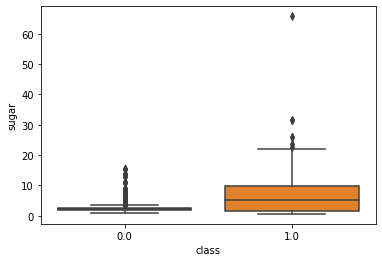

In [75]:
import seaborn as sns
# sns.scatterplot(data = wine, x='pH', y='sugar',hue='class')
sns.boxplot(data = wine, x='class', y='sugar')

- 복원 추출
  - 한번도 추출이 안된 샘플이 있을 수 있음

In [80]:
# 복원추출
rf = RandomForestClassifier(n_jobs=-1, oob_score=True , random_state=42)
rf.fit(train_input, train_target)
#한번도 추출이 안된 샘플
print(rf.oob_score_) # 검증 세트와 비슷한 느낌

print(rf.score(train_input, train_target))
print(rf.score(test_input, test_target))

0.8934000384837406
0.996921300750433
0.8892307692307693


## 확률적 경사하강법
- 점진적 학습이라 함
  - 대표적 알고리즘 : 확률적 경사 하강법(Stochastic Gradient Descent)
  - 확률적의 의미 : 무작위

- 훈련 세트 분리
  - 샘플 뽑기
    - 확률적 경사 하강법 : 1개씩 뽑기
    - 미니배치 경사 하강법 : 여러개씩 뽑기
    - 배치 경사 하강법 : 몽땅 꺼내기
  - 조금씩 경사 및 기울기를 따라 이동
  - 모든 훈련세트 소진 : 1에포크 끝

- 손실함수 (loss function)
  - 머신러닝 알고리즘이 얼마나 잘 못맞추느냐 측정하는 기준
  - 손실 함수의 값은 작을수록 좋음


## 그레이디언트 부스팅
- 처음에 샘플 뽑고, 경사하강법을 적용
  - 사용하는 모델은 결정 트리
  - 조금씩 범위를 늘려나가며 탐색

In [83]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators = 500,
                                learning_rate = 0.2,
                                subsample = 0.5, # 전체 훈련 세트 = 1.0
                                random_state=42)

scores = cross_validate(gb, train_input, train_target, return_train_score = True, n_jobs = -1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9434289514154802 0.8751230843266453


## XGBoost vs LightGBM
- Decision Tree
- LightGBM은 중간부터 노드분기 x
- 노드가 분기 -> 속도 차이
  - LigGBM > XGBoost
- GPU 지원 여부
  - 기존 알고리즘(선형, 결정트리, 랜덤포레스트, 일반 부스팅) : x
  - XGBoost, LightGBM : o
- 공통적인 특징(문법상 미세한 차이 발생)
  - Scikit-Learn과 연동된 API
  - 독자적인 API
  - 약간의 문법적인 혼동이 옴
---

## LightGBM
- pandas 데이터프레임 -> numpy 배열 -> Dataset API --> 모델

## XGBoost
- pandas 데이터프레임 -> numpy 배열 -> DMatrix --> 모델

---

### Scikit-Learn API

In [87]:
from xgboost import XGBClassifier
xgb = XGBClassifier(tree_method='hist', random_state=42)
scores = cross_validate(xgb, train_input, train_target, return_train_score=True)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.8824322471423747 0.8726214185237284


In [ ]:
import xgboost as xgb

# read in data
dtrain = xgb.DMatrix('demo/data/agaricus.txt.train')
dtest = xgb.DMatrix('demo/data/agaricus.txt.test')

#specify parameters via map
param = {'max_depth':2, 'eta':1, 'objective':'binary'}
num_round = 2

bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)

In [86]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(random_state=42)
scores = cross_validate(lgb, train_input, train_target, return_train_score=True, n_jobs = -1)

print(np.mean(scores['train_score']), np.mean(scores['test_score']))

0.9338079582727165 0.8789710890649293


## 머신러닝 프로세스
- 데이터 수집
- 데이터 전처리
  - Feature Engineering(표준화), 각 수치 데이터의 단위가 다름
- 머신러닝 모델
  - 분류
  - 회귀(수치 예측)
  - KNN, 선형회귀, 로지스틱 회귀, 결정트리(랜덤포레스트 등), 경사하강법
- 하이퍼파라미터, 교차검증
  - 그리드 서치
  - 랜덤 서치
- 평가지표
  - 분류 : 정확도
  - 회귀 : MAE